In [1]:

import pandas as pd
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['deleted', 'removed'])

In [4]:
df = pd.read_csv('2017-end2021.csv')
print(len(df))

165490


In [5]:
data = df.body.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(data))

[['if', 'wanted', 'to', 'get', 'emotionally', 'battered', 'and', 'fucked', 'repeatedly', 'visit', 'my', 'in', 'laws']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['if', 'wanted', 'to', 'get', 'emotionally', 'battered', 'and', 'fucked', 'repeatedly', 'visit', 'my', 'in', 'laws']


In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

[['want', 'get', 'emotionally', 'batter', 'fuck', 'repeatedly', 'visit', 'law']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [11]:
mallet_path = '/Users/stuartbman/GitHub/reddit_scraper/mallet/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.

In [13]:
find_optimal_model=False # Change this setting to iterate over topic n and find optimal coherence (Elbow)

# Show graph
if find_optimal_model:
    limit=20
    start=6
    step=2
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [14]:
if find_optimal_model:
    optimal_model = model_list[4] #select model index from graph above
else:
    optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word)

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
pyLDAvis.save_html(vis, 'test.html')

165490


In [166]:
model.save('optimal_model.model')

In [ ]:
## Output topic keyword list as a csv

import csv

model.print_topics()

n_words = 10 # Number of words per topic

topic_words = pd.DataFrame({})

with open('topics.csv','w') as csvfile:
    writer=csv.writer(csvfile)
    for i, topic in enumerate(model.get_topics()):
        top_feature_ids = topic.argsort()[-n_words:][::-1]
        feature_values = topic[top_feature_ids]
        words = [id2word[id] for id in top_feature_ids]
        writer.writerow(words)
        topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
        topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

In [116]:
## Manually label topic titles.

topic_titles={
    0: 'Emotions & Support',
    1: 'Training',
    2: 'Work life balance',
    3: 'MDT & Teamwork',
    4: 'Misc',
    5: 'Clinical',
    6: 'Pay & Remuneration',
    7: 'Impact of covid',
    8: 'Exams',
    9: 'Career progression',
    10: 'Working hours',
    11: 'Jobs & applications',
    12: 'Role of a doctor',
    13: 'Hospital reviews'
}

In [17]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.0935,"good, hospital, lot, great, place, bit, pretty...","""If I wanted to get emotionally battered and f..."
1,1,11.0,0.1779,"point, interview, application, score, research...",I think there’s a few things:\n\n- I had such ...
2,2,3.0,0.1194,"patient, call, ward, nurse, team, senior, staf...",I rarely hear it from doctors. Most have been...
3,3,5.0,0.2252,"patient, give, risk, high, case, treatment, lo...",and what about CO2 and monitoring? \n\na ward ...
4,4,4.0,0.1278,"post, comment, agree, hear, lol, reply, guess,...","Conscious or not, it’s not the truth. You’ll m..."
5,5,5.0,0.2765,"patient, give, risk, high, case, treatment, lo...",> give some PEEP via the waters circuit\n\nbe ...
6,6,13.0,0.1051,"good, hospital, lot, great, place, bit, pretty...","No traffic this week, it's amazing!"
7,7,5.0,0.3292,"patient, give, risk, high, case, treatment, lo...",> I’m a fan of roc only.\n\nSame.\n\nIf they'r...
8,8,3.0,0.1241,"patient, call, ward, nurse, team, senior, staf...",Oh. I think you'll find that it's the fact laz...
9,9,8.0,0.0847,"good, time, find, question, thing, exam, part,...","yup, way more iphones in my experience, especi..."


In [18]:
df_dominant_topic['sentiment']=df['sentiment']
df_dominant_topic['created_utc']=df['created_utc']

In [130]:
remove_zero=True #Change this if you don't want to remove sentiments approximately zero
if remove_zero:
    print(len(df_dominant_topic))
    df=df_dominant_topic
    df_unremove = df_dominant_topic
    df = df.drop(df[(df.sentiment < 0.05) & (df.sentiment > -0.05)].index)
    df_dominant_topic=df
    print(len(df_dominant_topic))

165490
123011


In [132]:
# For undoing zero removal without redoing the whole process

unremove_zero = True
if unremove_zero:
    df_dominant_topic=df_unremove

In [165]:
## Calculate the median and % share of positive/neutral/negative comments

topic_sentiment=df_dominant_topic.groupby('Dominant_Topic')['sentiment'].mean().to_frame()
topic_sentiment['median']=df_dominant_topic.groupby('Dominant_Topic')['sentiment'].median()
topic_sentiment['positive']=df_dominant_topic.groupby('Dominant_Topic').apply(lambda df: sum(df.sentiment > 0.05)/len(df.sentiment))
topic_sentiment['neutral']=df_dominant_topic.groupby('Dominant_Topic').apply(lambda df: sum(df.sentiment.between(-0.05,0.05))/len(df.sentiment))
topic_sentiment['negative']=df_dominant_topic.groupby('Dominant_Topic').apply(lambda df: sum(df.sentiment < -0.05)/len(df.sentiment))


pd.set_option('display.precision', 3)
topic_sentiment


,sentiment,median,positive,neutral,negative
Dominant_Topic,,,,,
0.0,0.054,0.000,0.231,0.629,0.139
1.0,0.288,0.318,0.602,0.216,0.182
2.0,0.315,0.395,0.635,0.160,0.205
3.0,0.146,0.103,0.515,0.170,0.315
4.0,0.199,0.273,0.572,0.188,0.239
5.0,0.091,0.000,0.484,0.163,0.353
6.0,0.196,0.223,0.560,0.144,0.296
7.0,0.182,0.153,0.536,0.193,0.271
8.0,0.343,0.421,0.667,0.163,0.170


Text(0, 0.5, 'Sentiment')

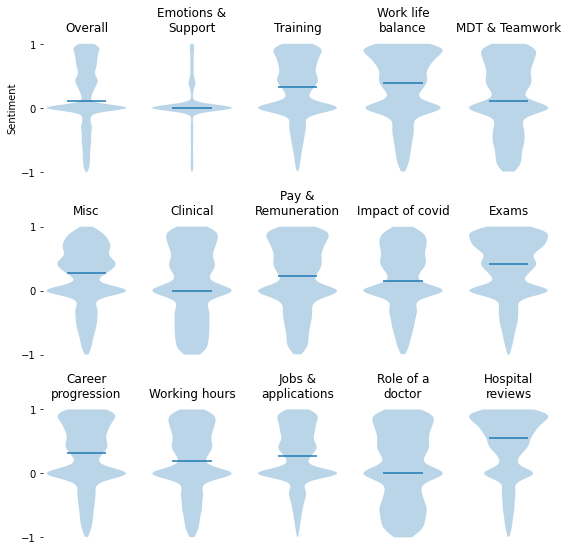

In [134]:
## Plot the

from textwrap import wrap

fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)
axs = axs.flatten()
axs[0].violinplot(df_dominant_topic['sentiment'], showmeans=False, showmedians=True, showextrema=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].title.set_text('Overall')
axs[0].set_ylabel('Sentiment')
for n, topic_n in enumerate(set(df_dominant_topic['Dominant_Topic'])):
    n+=1
    grouped=df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_n]
    axs[n].violinplot(grouped['sentiment'], showmeans=False, showmedians=True, showextrema=False)
    axs[n].title.set_text("\n".join(wrap(topic_titles[n-1],15)))
    axs[n].spines['top'].set_visible(False)
    axs[n].spines['right'].set_visible(False)
    axs[n].spines['bottom'].set_visible(False)
    axs[n].spines['left'].set_visible(False)
    axs[0].set_ylabel('Sentiment')
    if n not in [0,5,10]:
        axs[n].axis('off')

plt.gcf().set_facecolor('white')
plt.rcParams['figure.figsize'] = [8, 8]
fig.tight_layout()
plt.yticks([-1,0,1])
plt.xticks([])
plt.ylabel('Sentiment')

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'sentiment', 'created_utc'],
      dtype='object')


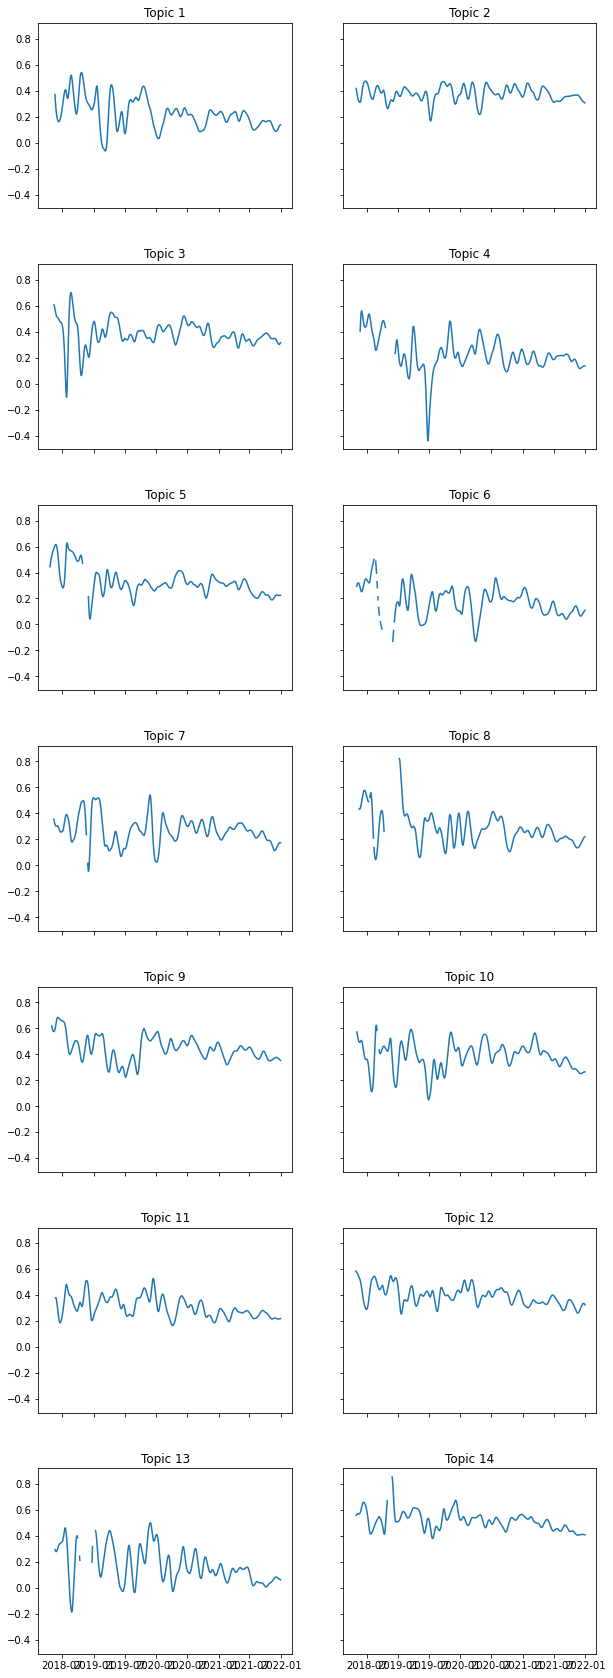

In [22]:
duration = 60
fig, axs = plt.subplots(nrows=7, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
print(df_dominant_topic.columns)
for n, topic_n in enumerate(set(df_dominant_topic['Dominant_Topic'])):
    topic_comments = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_n]
    topic_comments['created_utc'] = pd.to_datetime(topic_comments['created_utc'], unit='s')
    topic_comments = topic_comments.set_index('created_utc')
    topic_comments = topic_comments.resample("1d").mean().rolling(window=duration, min_periods=10, win_type='hanning').mean()
    topic_comments['sentiment_sem'] = topic_comments.resample("1d")['sentiment'].mean().rolling(window=duration, min_periods=10).sem()
    axs[n].plot(topic_comments['sentiment'])

    axs[n].title.set_text('Topic {}'.format(n+1))
plt.rcParams['figure.figsize'] = [10, 20]
plt.subplots_adjust(hspace=0.3)
plt.gcf().set_facecolor('white')
plt.show()

In [62]:
df['created_utc'] = pd.to_datetime(df_dominant_topic['created_utc'], unit='s')
df_i = df_dominant_topic.set_index('created_utc')

df2 = df_i.resample("1d").mean().rolling(window=duration, min_periods=10, win_type='hanning').mean()
df2['sentiment_sem'] = df_i.resample("1d")['sentiment'].mean().rolling(window=duration, min_periods=10).sem()
df2['count'] = df_i.resample('1d').apply({'score': 'count'})

plt.plot(df2['sentiment'])
plt.fill_between(df2.index,
                 df2['sentiment'] - df2['sentiment_sem'],
                 df2['sentiment'] + df2['sentiment_sem'],
                 alpha=0.5, )
plt.ylabel('Sentiment')
plt.twinx()
plt.bar(df2.index, df2['count'], alpha=0.2, color='k')
plt.ylabel('Daily comment count')

KeyError: "Column(s) ['score'] do not exist"

In [185]:
import numpy as np
from scipy.stats import sem
# Descriptive statistics
string_len=df_dominant_topic.Text.str.len()
word_len = df_dominant_topic.Text.str.split(' ').str.len()

total=len(df_dominant_topic)
pos=len(df_dominant_topic[df_dominant_topic.sentiment>0.05].index)
neg=len(df_dominant_topic[df_dominant_topic.sentiment< -0.05].index)
neut=total-pos-neg
print('{:.2f} (SD {:.2f}) mean chars per comment'.format(np.mean(string_len),np.std(string_len)))
print('{:.2f} (SD {:.2f}) mean words per comment'.format(np.mean(word_len),np.std(word_len)))
print('{} total comments '.format(total))
print('{} positive comments ({:.1%})'.format(pos,pos/total))
print('{} neutral comments ({:.1%})'.format(neut, neut/total))
print('{} negative comments ({:.1%})'.format(neg, neg/total))


291.51 (SD 429.38) mean chars per comment
51.32 (SD 75.12) mean words per comment
165490 total comments 
85417 positive comments (51.6%)
42491 neutral comments (25.7%)
37582 negative comments (22.7%)
